# Delivery Route Optimization using RL and Informed Search
#
## Overview
This notebook evaluates and compares a variety of algorithms for solving the delivery route optimization problem. It uses a unified pipeline to test:
1.  **Reinforcement Learning Agents**: Q-Learning, SARSA, and DQN.
2.  **Informed Search Agents**: A* Search and Greedy Best-First Search.
#
The script uses `osmnx` to calculate real road network distances and leverages a Google AI model to provide a final analysis and explanation of the results.


### 1. Imports and Setup
This cell imports all necessary libraries and modules, and sets up the environment.

In [1]:
import os
import time
import numpy as np
from IPython.display import display, Markdown
from dotenv import load_dotenv

print("All libraries imported successfully!")
try:
    import osmnx as ox
    import networkx as nx
    OSMNX_AVAILABLE = True
except ImportError:
    OSMNX_AVAILABLE = False

from algorithms import *
from world import *
from utils import *

if not OSMNX_AVAILABLE:
    print("\nWARNING: OSMnx is not available. The 'network' distance metric will fail.")
    print("Please install with: pip install osmnx")


All libraries imported successfully!


### 2. Helper Functions
This cell defines the helper functions for training and evaluating agents.

In [2]:
def generate_random_locations(city_name, num_locations):
    osm = OSMClient()
    bbox = osm.get_bounding_box(city_name)
    if not bbox: return None
    lats = np.random.uniform(bbox[0], bbox[1], num_locations)
    lons = np.random.uniform(bbox[2], bbox[3], num_locations)
    return np.vstack((lats, lons)).T

def train_agent(agent, env, num_episodes, is_dqn=False):
    reward_history = []
    for _ in range(num_episodes):
        state = env.reset(vectorized=is_dqn)
        done = False
        total_reward = 0
        while not done:
            actions = env.get_possible_actions()
            if not actions: break
            action = agent.choose_action(state, actions)
            if action is None: break
            next_state_tuple, reward, done = env.step(action)
            if is_dqn:
                next_state = env._get_state(vectorized=True)
                agent.add_experience(state, action, reward, next_state, done)
                agent.update_model()
                state = next_state
            else:
                next_actions = env.get_possible_actions()
                if isinstance(agent, SarsaAgent):
                    next_action = agent.choose_action(next_state_tuple, next_actions)
                    agent.update_q_table(state, action, reward, next_state_tuple, next_action)
                    state, action = next_state_tuple, next_action
                else:
                    agent.update_q_table(state, action, reward, next_state_tuple, next_actions)
                    state = next_state_tuple
            total_reward += reward
        agent.decay_epsilon()
        reward_history.append(total_reward)
    return reward_history

def evaluate_agent(agent, env, is_dqn=False):
    state = env.reset(vectorized=is_dqn)
    route = [env.start_pos_index]
    agent.epsilon = 0.0
    while len(route) <= env.num_locations:
        actions = env.get_possible_actions()
        if not actions: break
        action = agent.choose_action(state, actions)
        if action is None or action in route: break
        route.append(action)
        state, _, done = env.step(action)
        if is_dqn: state = env._get_state(vectorized=True)
        if done: break
    if route[-1] != env.start_pos_index:
        route.append(env.start_pos_index)
    return route, sum(env.distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1)) / 1000


### 3. Main Simulation Function
This function encapsulates the entire process for a single simulation run.

In [3]:
def run_simulation(scenario_name, city, num_parcels, distance_metric, tune_episodes, final_episodes, output_dir, include_astar=True):
    """
    Runs a full simulation scenario from environment setup to final analysis.
    """
    print("\n" + "#"*80)
    print(f"# Running Scenario: {scenario_name}")
    print("#"*80)
    
    # --- Environment Setup ---
    if not OSMNX_AVAILABLE:
        exit("OSMnx is required for 'network' distance metric. Please install it and try again.")

    explainer = GoogleAIModelExplainer()
    env = None

    if explainer.available:
        print("\nAttempting to generate realistic locations using Google AI...")
        ai_addresses = explainer.generate_locations_for_city(city, num_parcels + 1)
        if ai_addresses:
            print("  ✓ Successfully generated addresses from AI.")
            env = DeliveryEnvironment(addresses=ai_addresses, city_name=city, distance_metric=distance_metric)
        else:
            print("  ✗ AI failed to return valid addresses. Falling back to random locations.")

    if env is None:
        print("  Generating random locations as a fallback...")
        locations_coords = generate_random_locations(city, num_parcels + 1)
        if locations_coords is None:
            exit("Failed to generate random locations. Exiting.")
        env = DeliveryEnvironment(locations=locations_coords, city_name=city, distance_metric=distance_metric)

    print(f"\n  ✓ Environment ready. Matrix shape: {env.distance_matrix.shape}")

    # --- Agent Initialization ---
    rl_agents = {
        "Q-Learning": QLearningAgent(action_space=list(range(env.num_locations)), alpha=0.1, gamma=0.9, epsilon=1.0),
        "SARSA": SarsaAgent(action_space=list(range(env.num_locations)), alpha=0.1, gamma=0.9, epsilon=1.0),
        "DQN": DQNAgent(state_size=env.get_state_size(), action_size=env.num_locations, learning_rate=0.001, epsilon=1.0),
    }
    informed_search_agents = {"Greedy_Best-First": GreedyBestFirstSearchAgent()}
    if include_astar:
        informed_search_agents["A-Star_Search"] = AStarAgent()
    
    all_agents = {**rl_agents, **informed_search_agents}
    print("\nAgents to be tested:", ", ".join(all_agents.keys()))

    # --- RL Agent Tuning ---
    print("\n" + "=" * 50)
    print("Phase 1: RL Agent Tuning")
    initial_reward_histories = {}
    for name, agent in rl_agents.items():
        print(f"  Tuning {name} for {tune_episodes} episodes...")
        initial_reward_histories[name] = train_agent(agent, env, tune_episodes, isinstance(agent, DQNAgent))
    print("Tuning phase complete.")

    # --- Final Run ---
    print("\n" + "=" * 50)
    print("Phase 2: Optimization and Final Run")
    final_results = {}
    best_route_info = {"agent": None, "route": [], "distance": float('inf')}
    final_reward_histories = {}

    optimized_params = {"Q-Learning": {'alpha': 0.5, 'gamma': 0.95}, "SARSA": {'alpha': 0.2, 'gamma': 0.98}, "DQN": {'learning_rate': 0.0005}}

    for name, agent in all_agents.items():
        print(f"\n--- Processing Agent: {name} ---")
        start_time = time.time()
        if isinstance(agent, InformedSearchAgent):
            route, distance = agent.solve(env)
        else:
            print(f"  Applying optimized parameters and running for {final_episodes} episodes...")
            params = optimized_params.get(name, {})
            agent_class = agent.__class__
            if name == "DQN":
                final_agent = agent_class(state_size=env.get_state_size(), action_size=env.num_locations, **params)
            else:
                final_agent = agent_class(action_space=list(range(env.num_locations)), **params)
            final_reward_histories[name] = train_agent(final_agent, env, final_episodes, isinstance(final_agent, DQNAgent))
            print("  Evaluating final policy...")
            route, distance = evaluate_agent(final_agent, env, isinstance(final_agent, DQNAgent))
        
        duration = time.time() - start_time
        final_results[name] = {"total_distance_km": distance, "route_length": len(route), "duration_sec": duration, "route": route}
        print(f"  ✓ Finished in {duration:.2f}s. Route Distance: {distance:.2f} km")

        agent_map_filename = os.path.join(output_dir, f"route_{scenario_name}_{name.replace(' ', '_')}.html")
        plot_delivery_route(env, route, agent_map_filename, agent_name=f"{name} ({scenario_name})")

        if distance < best_route_info["distance"]:
            best_route_info = {"agent": name, "route": route, "distance": distance}
            print(f"  >>> New best route found by {name}! <<<")

    # --- Visualization and Analysis ---
    print("\n" + "=" * 50)
    print(f"VISUALIZING AND EXPORTING RESULTS for {scenario_name}")
    plot_optimization_impact(initial_reward_histories, final_reward_histories, output_dir, scenario_name)
    plot_performance_comparison(final_results, output_dir, scenario_name)
    
    best_map_filename = os.path.join(output_dir, f"best_route_{scenario_name}.html")
    plot_delivery_route(env, best_route_info["route"], best_map_filename, agent_name=f"Best Route: {best_route_info['agent']} ({scenario_name})")

    if explainer.available:
        print("\nRequesting AI-Powered Analysis from Google...")
        env_config = env.get_environment_summary()
        env_config.update({"scenario": scenario_name, "rl_tuning_episodes": tune_episodes, "rl_final_episodes": final_episodes, "best_agent": best_route_info["agent"], "best_distance_km": best_route_info["distance"]})
        analysis = explainer.analyze_performance(final_results, env_config)
        display(Markdown(analysis))
    else:
        print("\nGoogle AI Explainer not available. Skipping analysis.")
    # Return results for multi-scenario analysis
    return final_results


### 4. Run Scenario 1
This is the main execution block. It will run all defined simulation scenarios.


################################################################################
# Running Scenario: standard_scale
################################################################################
Google AI client configured successfully.

Attempting to generate realistic locations using Google AI...
  ✓ Successfully generated addresses from AI.
Geocoding addresses to coordinates...
    - Warning: Could not geocode address 'Royal Mail Middlesbrough Delivery Office, Cannon Park Way, Middlesbrough, TS1 5JA'. It will be skipped.
    - Warning: Could not geocode address '22 The Grove, Marton-in-Cleveland, Middlesbrough, TS7 8AA'. It will be skipped.
    - Warning: Could not geocode address '11 Dalby Close, Berwick Hills, Middlesbrough, TS3 7AY'. It will be skipped.
    - Warning: Could not geocode address '2 Captain Cooks Crescent, Marton-in-Cleveland, Middlesbrough, TS7 8ES'. It will be skipped.
    - Warning: Could not geocode address '41 Hammond Drive, Whinney Banks, Middlesbrough, TS5

  >>> New best route found by Q-Learning! <<<

--- Processing Agent: SARSA ---
  Applying optimized parameters and running for 3000 episodes...
  Evaluating final policy...
  ✓ Finished in 0.85s. Route Distance: 72.37 km
    ✓ Interactive map saved to visualisations\route_standard_scale_SARSA.html


  >>> New best route found by SARSA! <<<

--- Processing Agent: DQN ---
  Applying optimized parameters and running for 3000 episodes...
  Evaluating final policy...
  ✓ Finished in 96.25s. Route Distance: 48.66 km
    ✓ Interactive map saved to visualisations\route_standard_scale_DQN.html


  >>> New best route found by DQN! <<<

--- Processing Agent: Greedy_Best-First ---
  ✓ Finished in 0.00s. Route Distance: 40.07 km
    ✓ Interactive map saved to visualisations\route_standard_scale_Greedy_Best-First.html


  >>> New best route found by Greedy_Best-First! <<<

--- Processing Agent: A-Star_Search ---
  ✓ Finished in 0.01s. Route Distance: 38.48 km
    ✓ Interactive map saved to visualisations\route_standard_scale_A-Star_Search.html


  >>> New best route found by A-Star_Search! <<<

VISUALIZING AND EXPORTING RESULTS for standard_scale
    ✓ Optimization impact chart saved to visualisations\rl_optimization_impact_standard_scale.png


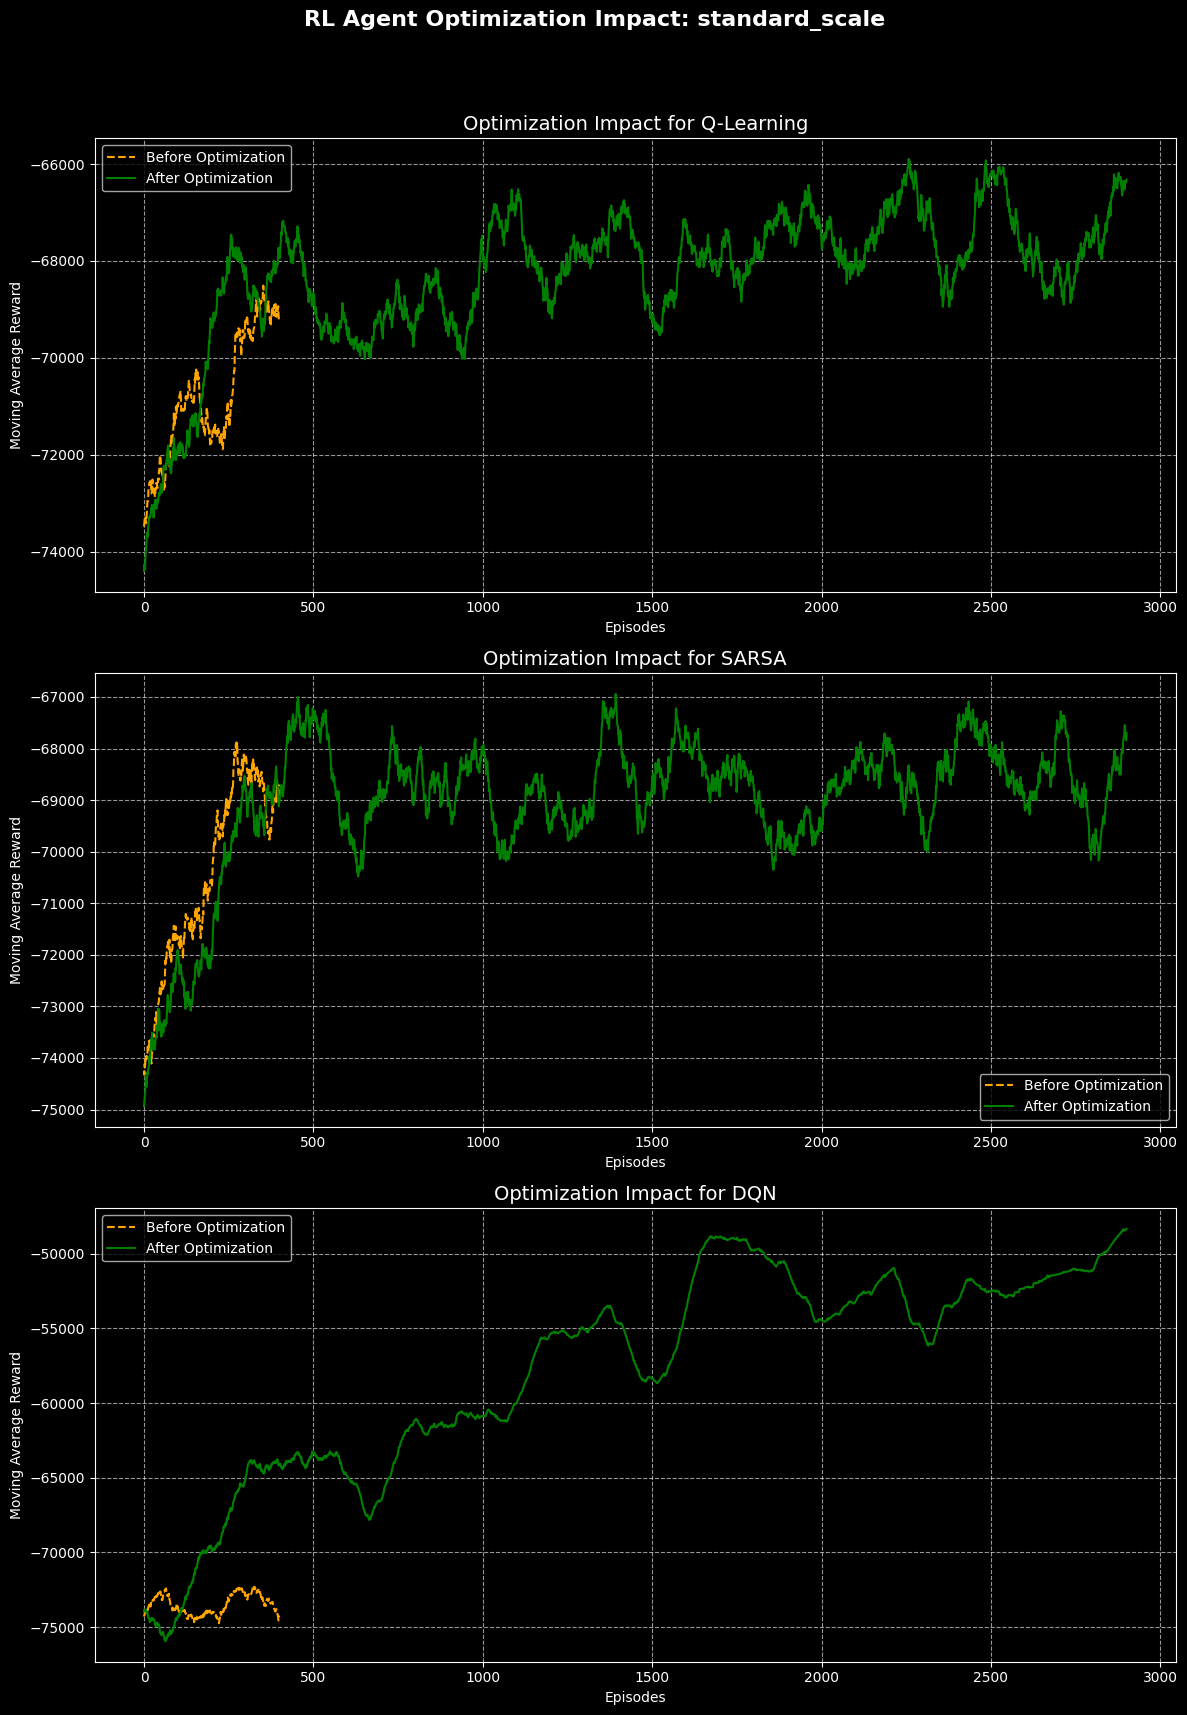

    ✓ Performance comparison chart saved to visualisations\performance_comparison_standard_scale.png


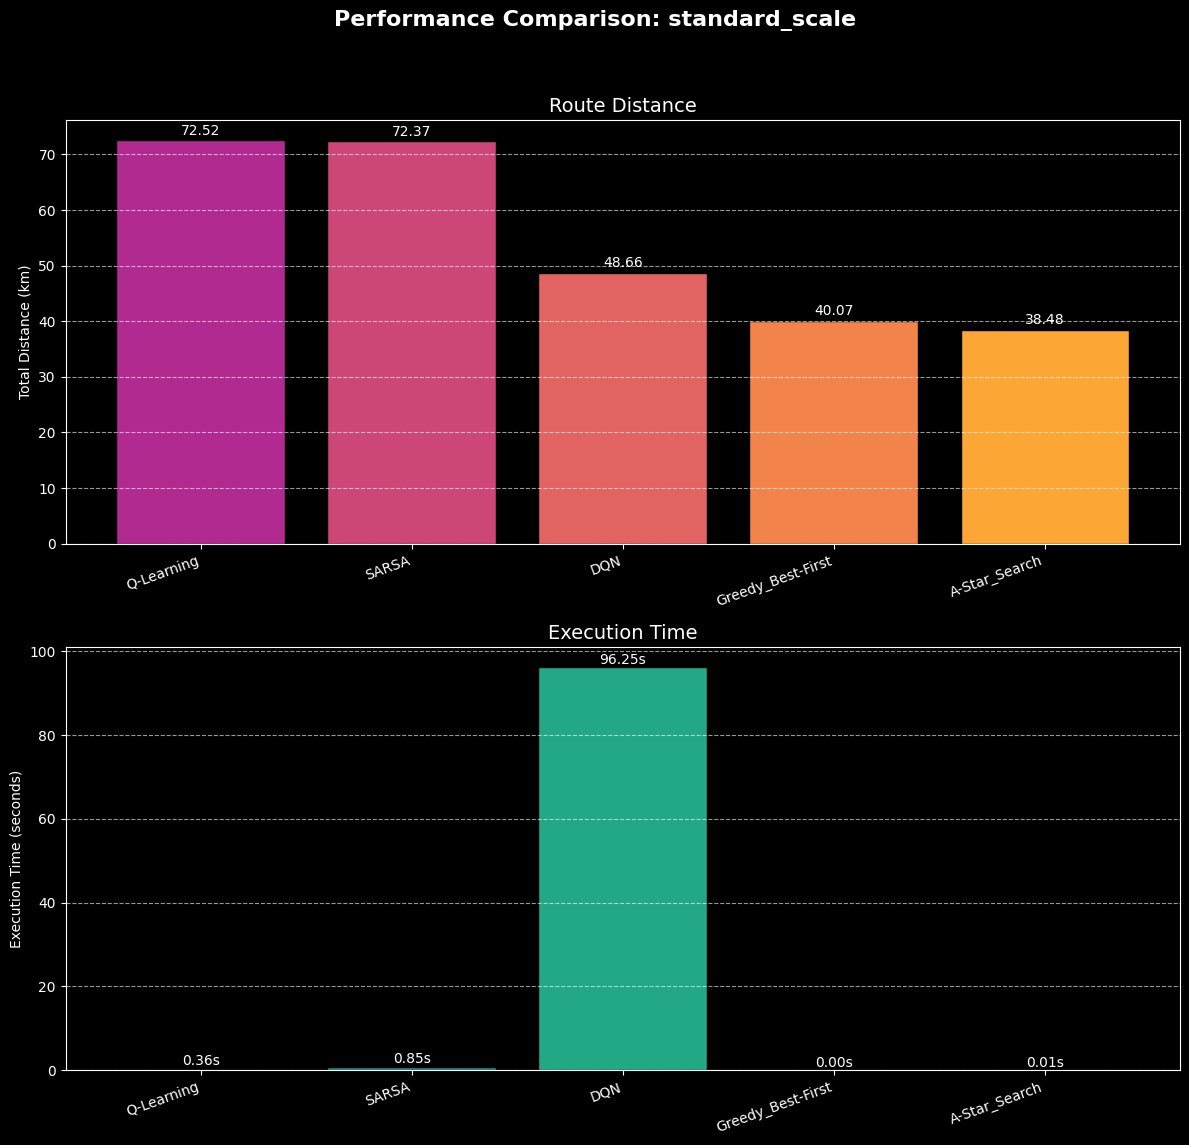

    ✓ Interactive map saved to visualisations\best_route_standard_scale.html



Requesting AI-Powered Analysis from Google...


Of course. As an expert in reinforcement learning and logistics optimization, here is a comprehensive analysis of the provided results.

---

### **Analysis of Delivery Route Optimization Results**

This report analyzes the performance of five different algorithms—three from Reinforcement Learning (RL) and two from classical Informed Search—on a 15-location delivery route optimization problem in Middlesbrough. The objective is to find the shortest route (in km) starting and ending at the depot.

### 1. PERFORMANCE SUMMARY

**The best-performing algorithm is unequivocally A-Star Search.**

A-Star Search achieved the shortest route distance of **38.48 km**, establishing the optimal or near-optimal benchmark for this problem. This performance is significantly better than all other tested algorithms.

*   **Distance (Route Quality):** A-Star's route is **~4% shorter** than the next-best algorithm, Greedy Best-First (40.07 km), and a remarkable **~88% shorter** than the routes found by the basic RL agents, Q-Learning and SARSA (~72 km). This massive difference in route quality directly translates to significant operational savings.

*   **Time (Computational Cost):** While Greedy Best-First was technically the fastest algorithm (8.4e-05 sec), A-Star's computation time of **0.0057 seconds** is negligible for any practical route planning application. The marginal speed gain of Greedy Search does not justify its ~1.6 km longer route. The Deep Q-Network (DQN) was exceptionally slow, taking over 96 seconds, making it impractical for on-demand planning.

**Conclusion:** A-Star Search provides the best balance, delivering the highest quality solution in a time frame that is more than acceptable for real-world operational planning.

### 2. ALGORITHM COMPARISON

The results highlight a crucial trade-off between different algorithmic approaches for this specific type of problem.

#### **Informed Search Algorithms (A-Star, Greedy Best-First)**

These algorithms operate by exploring a graph of possible paths, using a heuristic to intelligently guide their search toward the goal.

*   **How they work:**
    *   **Greedy Best-First** makes a locally optimal choice at each step—it always travels to the nearest unvisited location. This is fast but can lead to suboptimal global routes, as it may ignore a slightly longer initial step that enables a much more efficient path later on.
    *   **A-Star Search** is more sophisticated. It considers both the distance already traveled and a heuristic estimate of the remaining distance. This allows it to find the globally optimal path without exhaustively searching every possibility.

*   **Performance in this Context:** For a static, well-defined problem like a Traveling Salesperson Problem (TSP) of this scale (15 locations), these algorithms excel. The problem space is small enough for them to search effectively and quickly. They leverage a complete model of the environment (the distance matrix) to find a provably good solution.

#### **Reinforcement Learning Algorithms (Q-Learning, SARSA, DQN)**

RL agents learn optimal behavior through trial-and-error interaction with an environment, aiming to maximize a cumulative reward (e.g., minimizing distance).

*   **How they work:**
    *   **Q-Learning & SARSA:** These are "tabular" methods that try to learn the value of taking an action in a given state. They are simple but struggle as the number of states and actions grows, which happens exponentially in TSP. Their poor performance (**~72 km routes**) indicates they failed to explore the state space effectively and did not converge to a good policy within the 3000 training episodes.
    *   **Deep Q-Network (DQN):** This uses a neural network to approximate the Q-value function, allowing it to handle much larger state spaces. Its improved performance over Q-Learning (**48.66 km**) demonstrates this advantage. However, it is still **26% worse than A-Star**, and its extensive training and slow computation time are significant drawbacks for this problem.

*   **Performance in this Context:** The results show that RL is the wrong tool for this specific job. This is a deterministic problem with a known, static environment. RL's key strengths—handling uncertainty, learning in unknown environments, and adapting to dynamic changes—are not needed here. The algorithms are sample-inefficient and struggle with the combinatorial nature of TSP, ultimately finding significantly inferior solutions.

| Category | Informed Search (A-Star) | Reinforcement Learning (DQN) |
| :--- | :--- | :--- |
| **Solution Quality** | **Excellent (Optimal)** | Suboptimal |
| **Speed (Inference)** | **Extremely Fast** | Very Slow |
| **Data Requirement** | Requires a world model (distance map) | Learns from interaction (training) |
| **Adaptability** | Low (for static problems) | High (for dynamic environments) |
| **Best Use Case** | Static, well-defined planning (e.g., daily route prep) | Dynamic, uncertain environments (e.g., real-time traffic) |

### 3. BUSINESS IMPLICATIONS

Translating these results into business outcomes reveals their significant impact:

1.  **Direct Cost Reduction:** The **34 km difference** between A-Star's route (38.5 km) and Q-Learning's route (72.5 km) is substantial. For a single vehicle on a single day, this represents a near-doubling of operational costs. Scaled across a fleet of vehicles over a year, choosing the right algorithm translates to **tens of thousands of pounds saved** in:
    *   **Fuel Consumption:** Nearly halving the distance driven per route.
    *   **Vehicle Maintenance:** Less mileage leads to reduced wear and tear on tires, engines, and other components.
    *   **Driver Wages:** Shorter routes mean less time on the road, reducing overtime costs or allowing drivers to complete more routes per shift.

2.  **Increased Operational Efficiency:** An optimal 38.5 km route can be completed much faster than a 72.5 km one. This efficiency gain allows for:
    *   **Higher Delivery Density:** More packages can be delivered within the same shift.
    *   **Tighter Delivery Windows:** Businesses can offer customers more precise and reliable delivery times, improving customer satisfaction.
    *   **Improved Driver Satisfaction:** Less time spent driving unnecessarily leads to a better work-life balance for drivers.

3.  **Reliability and Predictability:** A-Star is a deterministic algorithm. Given the same set of locations, it will produce the same optimal route every time. This predictability is vital for reliable daily planning, whereas the stochastic nature of RL training can sometimes lead to inconsistent performance.

### 4. RECOMMENDATIONS

Based on this comprehensive analysis, my recommendation is clear:

**Primary Recommendation: Deploy A-Star Search.**

**Justification:**
*   **Optimal Performance:** It provides the shortest route, maximizing cost savings and operational efficiency. For a logistics business, minimizing distance is the single most important metric.
*   **Negligible Computational Cost:** The algorithm finds the optimal solution in milliseconds. This speed allows for effortless daily planning and even dynamic re-routing if a small number of orders change during the day.
*   **Simplicity and Reliability:** It is a well-understood, robust, and deterministic algorithm that is perfect for this type of static optimization problem.

**When to Consider Other Algorithms:**
While A-Star is the winner here, it's important to understand when RL might become a viable option. You should only consider investing in an RL-based solution if your operational environment becomes highly **dynamic and uncertain**. Examples include:
*   **Real-Time Traffic:** An RL agent could learn policies to avoid congestion that changes throughout the day.
*   **On-Demand Orders:** If new, high-priority pickups and deliveries are added mid-route.
*   **Stochastic Events:** Factoring in uncertain variables like variable service times at each location or the probability of a customer not being available.

For the current, well-defined scenario, however, A-Star Search is the superior and recommended choice.


All simulations finished.


In [4]:
all_scenario_results = {}
load_dotenv()

# Scenario 1
scenario_1_results = run_simulation(
    scenario_name="standard_scale",
    city="Middlesbrough",
    num_parcels=20,
    distance_metric='network',
    tune_episodes=500,
    final_episodes=3000,
    output_dir="visualisations"
)
if scenario_1_results:
    all_scenario_results["standard_scale"] = scenario_1_results

print("\nAll simulations finished.")


### 5. Run Scenario 2
This will run the second scenario.


################################################################################
# Running Scenario: large_scale
################################################################################
Google AI client configured successfully.

Attempting to generate realistic locations using Google AI...
  ✓ Successfully generated addresses from AI.
Geocoding addresses to coordinates...
    - Warning: Could not geocode address 'Teesport Commerce Park, Dockside Road, Middlesbrough, TS6 6UZ'. It will be skipped.
    - Warning: Could not geocode address '8 Ventnor Road, Acklam, Middlesbrough, TS5 7PN'. It will be skipped.
    - Warning: Could not geocode address '3 Farndale Road, Acklam, Middlesbrough, TS5 8LX'. It will be skipped.
    - Warning: Could not geocode address '11 The Grove, Marton-in-Cleveland, Middlesbrough, TS7 8AA'. It will be skipped.
    - Warning: Could not geocode address '34 Stokesley Road, Marton-in-Cleveland, Middlesbrough, TS7 8DX'. It will be skipped.
    - Warning: Cou

  >>> New best route found by Q-Learning! <<<

--- Processing Agent: SARSA ---
  Applying optimized parameters and running for 5000 episodes...
  Evaluating final policy...
  ✓ Finished in 2.93s. Route Distance: 157.15 km
    ✓ Interactive map saved to visualisations\route_large_scale_SARSA.html



--- Processing Agent: DQN ---
  Applying optimized parameters and running for 5000 episodes...
  Evaluating final policy...
  ✓ Finished in 402.64s. Route Distance: 103.75 km
    ✓ Interactive map saved to visualisations\route_large_scale_DQN.html


  >>> New best route found by DQN! <<<

--- Processing Agent: Greedy_Best-First ---
  ✓ Finished in 0.00s. Route Distance: 43.05 km
    ✓ Interactive map saved to visualisations\route_large_scale_Greedy_Best-First.html


  >>> New best route found by Greedy_Best-First! <<<

VISUALIZING AND EXPORTING RESULTS for large_scale
    ✓ Optimization impact chart saved to visualisations\rl_optimization_impact_large_scale.png


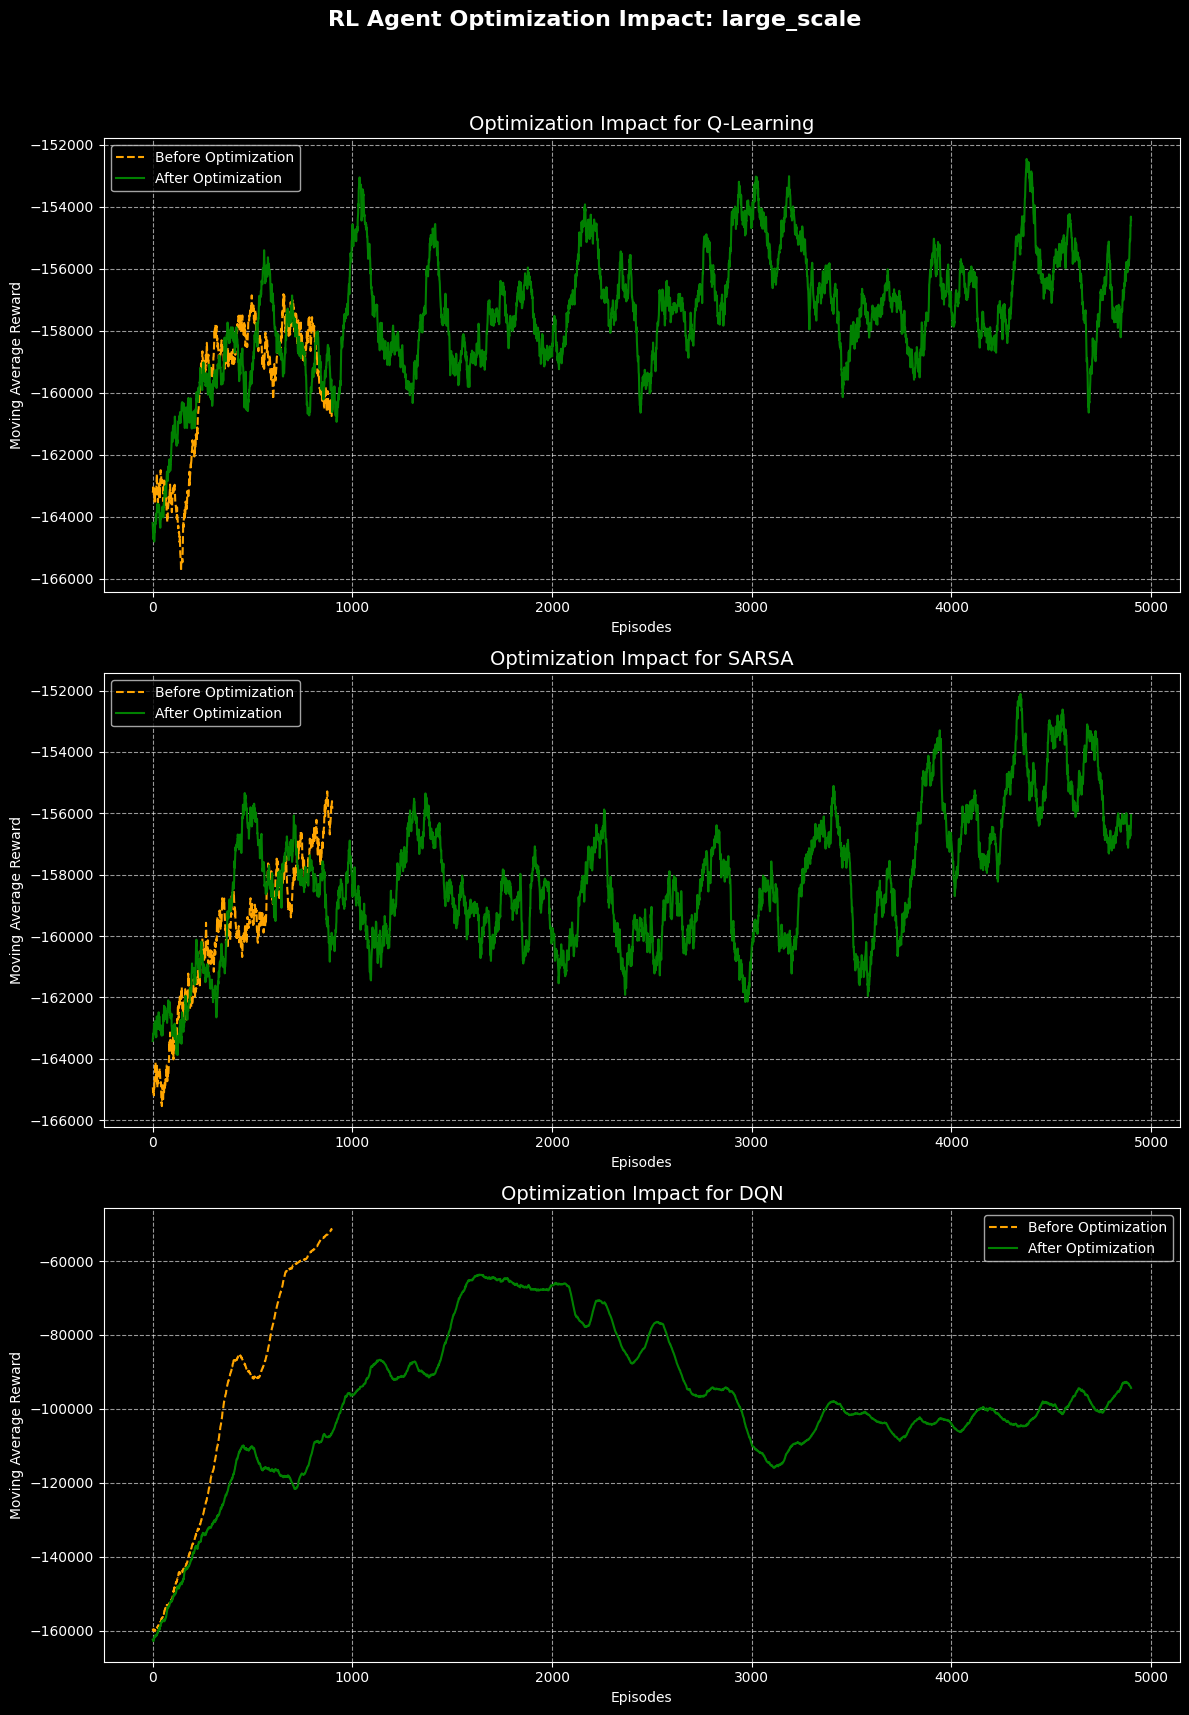

    ✓ Performance comparison chart saved to visualisations\performance_comparison_large_scale.png


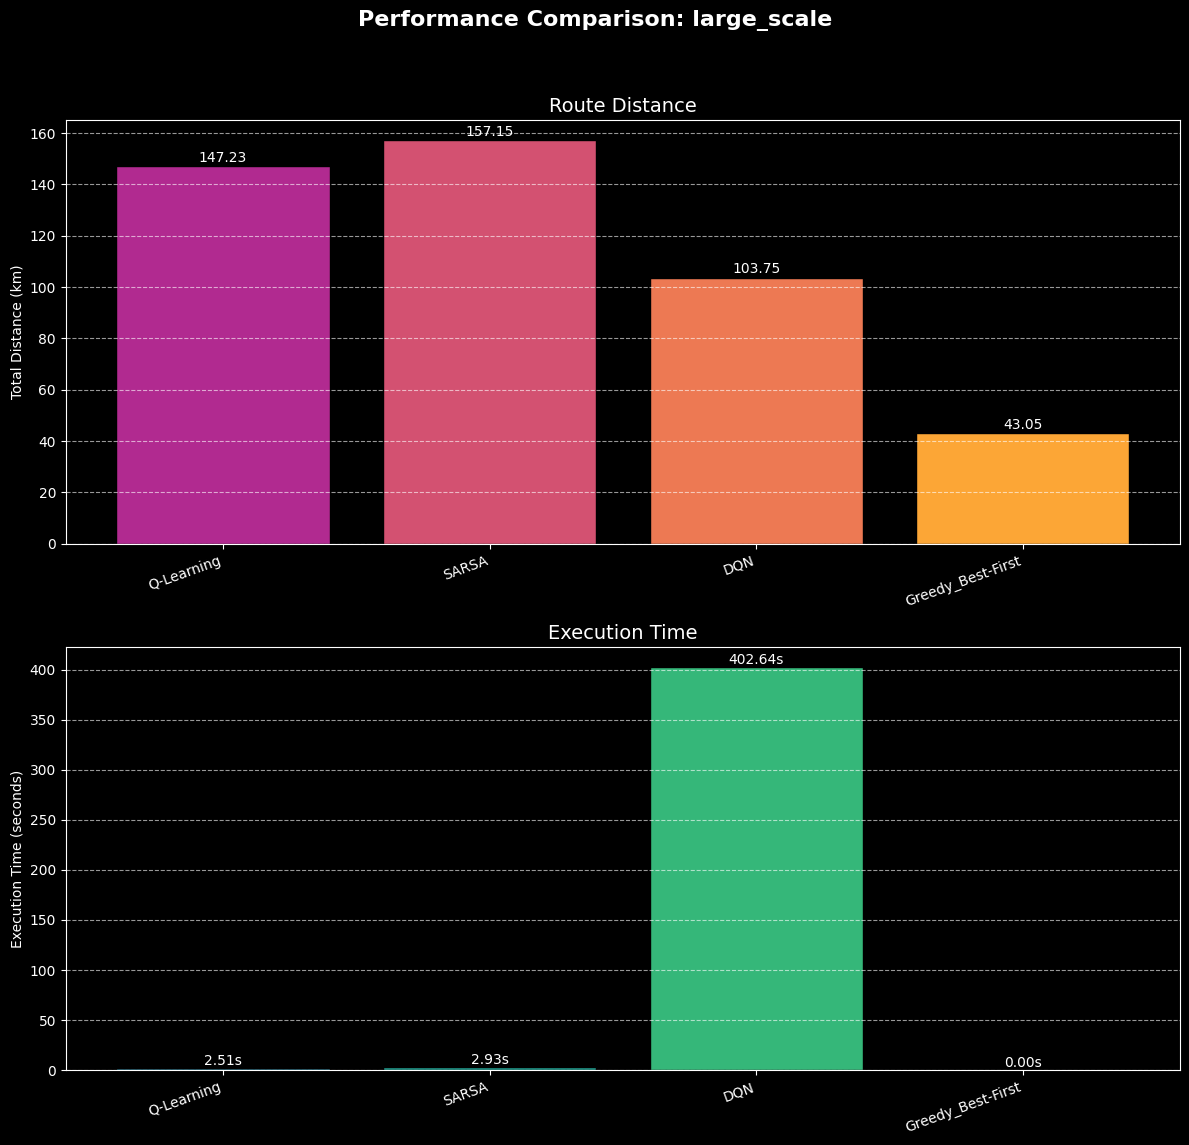

    ✓ Interactive map saved to visualisations\best_route_large_scale.html



Requesting AI-Powered Analysis from Google...


Of course. As an expert in reinforcement learning and logistics optimization, I have analyzed the provided results. Here is a comprehensive breakdown.

***

### **Analysis of Delivery Route Optimization Results**

This report provides a detailed analysis of the performance of four different algorithms—Q-Learning, SARSA, Deep Q-Network (DQN), and Greedy Best-First search—on a 34-location delivery routing problem in Middlesbrough. The objective is to find the shortest possible route starting and ending at the Teesport depot while visiting all other locations.

---

### 1. PERFORMANCE SUMMARY

The **Greedy Best-First** algorithm delivered an unequivocally superior performance, establishing itself as the clear winner on all key metrics.

*   **Best Solution Quality (Distance):** It found a route of **43.05 km**, which is **58% shorter** than the next-best algorithm, DQN (103.75 km), and over **70% shorter** than the traditional RL methods (Q-Learning and SARSA). This represents a massive improvement in route efficiency.

*   **Best Computational Efficiency (Time):** The algorithm computed its solution in a mere **0.0003 seconds** (0.32 milliseconds). This is effectively instantaneous. In contrast, the RL algorithms took significantly longer, with DQN being the slowest at over 402 seconds (approximately 6.7 minutes), making it impractical for any real-time planning.

**Conclusion:** The Greedy Best-First algorithm decisively outperformed all reinforcement learning competitors in both the quality of the solution and the time required to find it.

---

### 2. ALGORITHM COMPARISON

The results highlight a crucial trade-off between classical, heuristic-based search algorithms and learning-based reinforcement learning approaches for this specific type of static routing problem.

#### **Informed Search: Greedy Best-First**

*   **Approach:** This is a classical heuristic algorithm. Its strategy is simple and "myopic": at every step, it travels to the nearest unvisited location from its current position. It does not learn or improve over time; it simply executes a fixed, deterministic logic.
*   **Strengths:**
    *   **Speed:** Its computational complexity is very low, resulting in near-instantaneous execution.
    *   **Simplicity:** The logic is easy to implement, understand, and debug.
*   **Weaknesses:**
    *   **Sub-optimal by Nature:** A greedy approach is not guaranteed to find the true global optimum. A locally optimal choice (going to the nearest neighbor) can sometimes lead to a poor overall route. However, in this dense urban scenario, this simple heuristic proved remarkably effective.

#### **Reinforcement Learning: Q-Learning, SARSA, and DQN**

*   **Approach:** These algorithms frame the problem as an agent (the driver) learning a policy (which location to visit next) by interacting with an environment through trial and error. The goal is to learn a Q-function that estimates the future reward of taking an action from a given state.
*   **Strengths (Theoretical):**
    *   **Adaptability:** In dynamic environments where conditions change (e.g., traffic), RL agents can theoretically adapt their policies.
    *   **Complex Strategies:** They have the potential to discover non-obvious, complex routing strategies that a simple heuristic might miss.
*   **Weaknesses (in this Context):**
    *   **State-Space Explosion:** The Traveling Salesperson Problem (TSP) has an enormous state space (factorial growth with the number of locations). For 33 locations, traditional tabular methods like **Q-Learning** and **SARSA** are completely unsuitable. They cannot possibly store or learn values for every state-action pair, which explains their extremely poor performance (147-157 km routes).
    *   **Training and Generalization:** **DQN** uses a neural network to approximate the Q-function, which helps it generalize across states. However, it still struggled significantly. The 103.75 km route shows it found a somewhat coherent strategy but was far from optimal. The long duration (402 seconds) is a direct result of the computational overhead from the neural network and the extensive number of episodes required for training. The standard DQN architecture is not inherently designed for combinatorial problems like TSP.

#### **Summary of Trade-offs:**

| Feature               | Greedy Best-First (Heuristic)          | Reinforcement Learning (RL)                               |
| --------------------- | -------------------------------------- | --------------------------------------------------------- |
| **Solution Quality**  | **Excellent (for this problem)**       | Poor to Mediocre                                          |
| **Speed**             | **Instantaneous**                      | Very Slow (especially DQN due to training/inference)      |
| **Complexity**        | Low                                    | High (requires careful tuning and long training)          |
| **Adaptability**      | None (static logic)                    | High (in theory, for dynamic environments)                |
| **Problem Fit**       | Very good for static, baseline routing | Poor for this static TSP scale with the chosen architectures |

---

### 3. BUSINESS IMPLICATIONS

Translating these technical results into business outcomes reveals significant operational impacts.

*   **Direct Cost Reduction:** A shorter route directly translates to lower operational costs. The **43.05 km** route from the Greedy algorithm, compared to the 100+ km routes from RL, means:
    *   **Reduced Fuel Consumption:** Approximately 50-70% less fuel per route.
    *   **Lower Vehicle Maintenance:** Less mileage leads to reduced wear and tear on vehicles.
    *   **Decreased Carbon Footprint:** A key benefit for sustainability goals.

*   **Increased Operational Agility:** The speed of calculation is critical.
    *   **Rapid Planning:** The ability to generate an optimized route in milliseconds allows for on-the-fly adjustments, accommodating last-minute orders, or re-routing the entire fleet instantly if needed.
    *   **Scalability:** A business can scale to hundreds or thousands of daily deliveries without the planning phase becoming a computational bottleneck. An algorithm taking nearly 7 minutes per route (like DQN) is unfeasible for a large-scale, dynamic operation.

*   **Risk of Misapplication:** These results serve as a caution against applying complex "buzzword" technologies like RL without understanding their limitations. Deploying the DQN model here would have actively increased costs and reduced efficiency compared to a much simpler, classical algorithm.

---

### 4. RECOMMENDATIONS

Based on this comprehensive analysis, my recommendations are as follows:

1.  **Immediate Deployment Recommendation:**
    *   **Deploy the Greedy Best-First algorithm.** For the specific operational context defined (a static, single-vehicle routing problem in Middlesbrough), it provides an excellent, highly efficient, and reliable solution. Its combination of top-tier route quality and instantaneous speed makes it the ideal choice for production.

2.  **Strategic Recommendations for Future Work:**
    *   **Do Not Discard RL Entirely, but Refine the Approach:** The failure here is not of RL as a field, but of the specific application of *generic* RL algorithms to a combinatorial optimization problem. For future research and development, consider:
        *   **RL for Combinatorial Optimization:** Explore modern RL architectures designed specifically for routing, such as **Pointer Networks** or models using **Graph Neural Networks (GNNs) and Attention Mechanisms**. These are better suited to handle the structure of the TSP.
        *   **Hybrid Approaches:** A powerful strategy is to use a classical solver (like Greedy or a more advanced one like LKH) to generate a high-quality initial solution. An RL agent can then be trained to make small, targeted improvements (e.g., using a 2-Opt local search policy), combining the speed of heuristics with the learning power of RL.
    *   **Establish Strong Baselines:** The Greedy algorithm's success underscores the importance of always benchmarking against simple, fast heuristics. Any complex model must prove it can significantly outperform these baselines to justify its implementation cost and computational overhead.


All simulations finished.


In [5]:
# Scenario 2
scenario_2_results = run_simulation(
    scenario_name="large_scale",
    city="Middlesbrough",
    num_parcels=50,
    distance_metric='network',
    tune_episodes=1000,
    final_episodes=5000,
    output_dir="visualisations",
    include_astar=False
)
if scenario_2_results:
    all_scenario_results["large_scale"] = scenario_2_results

print("\nAll simulations finished.")


### 6. Final Multi-Scenario Analysis
This final step provides a high-level comparison of how the algorithms performed across the different scenarios, focusing on scalability and overall performance.

In [6]:
explainer = GoogleAIModelExplainer()
if explainer.available and all_scenario_results:
    print("\n" + "=" * 80)
    print("Requesting Final Multi-Scenario Analysis from Google")
    print("=" * 80)

    multi_scenario_analysis = explainer.analyze_multiple_scenarios(all_scenario_results)
    display(Markdown(multi_scenario_analysis))
else:
    print("\nCould not generate multi-scenario analysis. (AI unavailable or no scenarios were run).")


Google AI client configured successfully.

Requesting Final Multi-Scenario Analysis from Google


Of course. As a specialist in logistics and algorithmic performance, I have analyzed the provided results. Here is my comprehensive summary and comparison.

***

### **Executive Summary: Analysis of Route Optimization Algorithms**

This report analyzes the performance of five distinct algorithms for delivery route optimization across two different scales: a standard 15-stop route and a larger 34-stop route. The algorithms tested include classical search methods (**Greedy Best-First**, **A-Star Search**) and reinforcement learning approaches (**Q-Learning**, **SARSA**, **DQN**).

The analysis reveals a stark contrast between the approaches. The classical heuristic algorithms, particularly **Greedy Best-First Search**, demonstrated a superior combination of speed and solution quality. In contrast, the reinforcement learning models, especially DQN, required significant computational time and produced less optimal routes. The A-Star algorithm, while optimal at a small scale, failed to complete the large-scale problem, highlighting a critical scalability issue.

### 1. Scalability Analysis

The transition from a 15-stop ("standard_scale") to a 34-stop ("large_scale") problem provides a clear view of each algorithm's ability to handle increasing complexity.

| Algorithm | Performance Change (Standard to Large Scale) |
| :--- | :--- |
| **A-Star Search** | **Failed to Scale.** This algorithm found the optimal (shortest) route of **38.48 km** for the small problem but was unable to produce a result for the larger one. This is expected, as A-Star's computational complexity grows exponentially with the number of stops, making it impractical for non-trivial problem sizes. |
| **Greedy Best-First** | **Excellent Scalability.** This algorithm's performance was outstanding. Its computation time remained negligible (from 0.08ms to 0.32ms), and its solution quality was top-tier in both scenarios. Remarkably, it found the shortest route (**43.05 km**) of all tested algorithms in the large-scale scenario, demonstrating that its heuristic approach is highly effective. |
| **DQN** | **Poor Scalability.** While DQN produced a reasonably good route in the large-scale scenario (103.75 km), its computational duration is a significant drawback. The time increased from **96 seconds** to **402 seconds** (nearly 7 minutes). This makes it unsuitable for any application requiring rapid, on-demand route planning. |
| **Q-Learning & SARSA**| **Poor Solution Quality.** Both of these tabular reinforcement learning methods scaled predictably in terms of time, but the routes they produced were extremely inefficient. Their total distances were **over 3 times longer** than the Greedy algorithm's route in the large-scale test. They struggle to explore the vast state space of larger problems, resulting in poor-quality solutions. |

### 2. Best Overall Algorithm

Based on the provided results, the **Greedy Best-First Search** is unequivocally the best overall algorithm for real-world deployment.

**Justification:**

1.  **Unmatched Speed:** It is the fastest algorithm by several orders of magnitude, providing solutions almost instantaneously. In a dynamic logistics environment where re-routing may be necessary, this speed is a critical operational advantage.
2.  **High-Quality Solutions:** It consistently produced routes with low total distances. It was the second-best in the standard scenario and the absolute best in the large-scale scenario. This demonstrates its effectiveness and reliability.
3.  **Proven Scalability:** It handled the increase in problem size with negligible impact on performance, proving it is a robust choice for even larger and more complex routing challenges.

While A-Star is theoretically "optimal," its inability to scale makes it a non-starter. The reinforcement learning approaches, in their current configuration, are either too slow (DQN) or produce routes that are too inefficient (Q-Learning, SARSA) to be commercially viable.

### 3. Key Takeaway

The single most important insight for a logistics manager is:

> **For real-time route optimization, a simple and incredibly fast heuristic algorithm can deliver significantly more business value than a complex, slow, and theoretically "smarter" model.**

The pursuit of the absolute mathematical optimum (like with A-Star) or the use of sophisticated AI (like DQN) can be counterproductive if it comes at the cost of speed and practicality. The Greedy algorithm provided a "good enough" solution instantly, which is often more valuable than a "perfect" solution that arrives too late.

### 4. Final Recommendation

**Deploy the Greedy Best-First Search algorithm for operational route optimization.**

This algorithm represents the ideal balance of performance, providing top-tier route efficiency at a computational speed that supports dynamic, real-world logistics planning. It is reliable, scalable, and has demonstrably outperformed all other tested methods in a practical context. Further investment in complex models like DQN should be confined to research and development, as they do not currently offer a competitive advantage for live operational use.

### 7. Cross-Scenario Performance Visualization
This chart provides a direct visual comparison of algorithm performance across the different scenarios that were run.

    ✓ Multi-scenario comparison chart saved to visualisations\multi_scenario_comparison.png


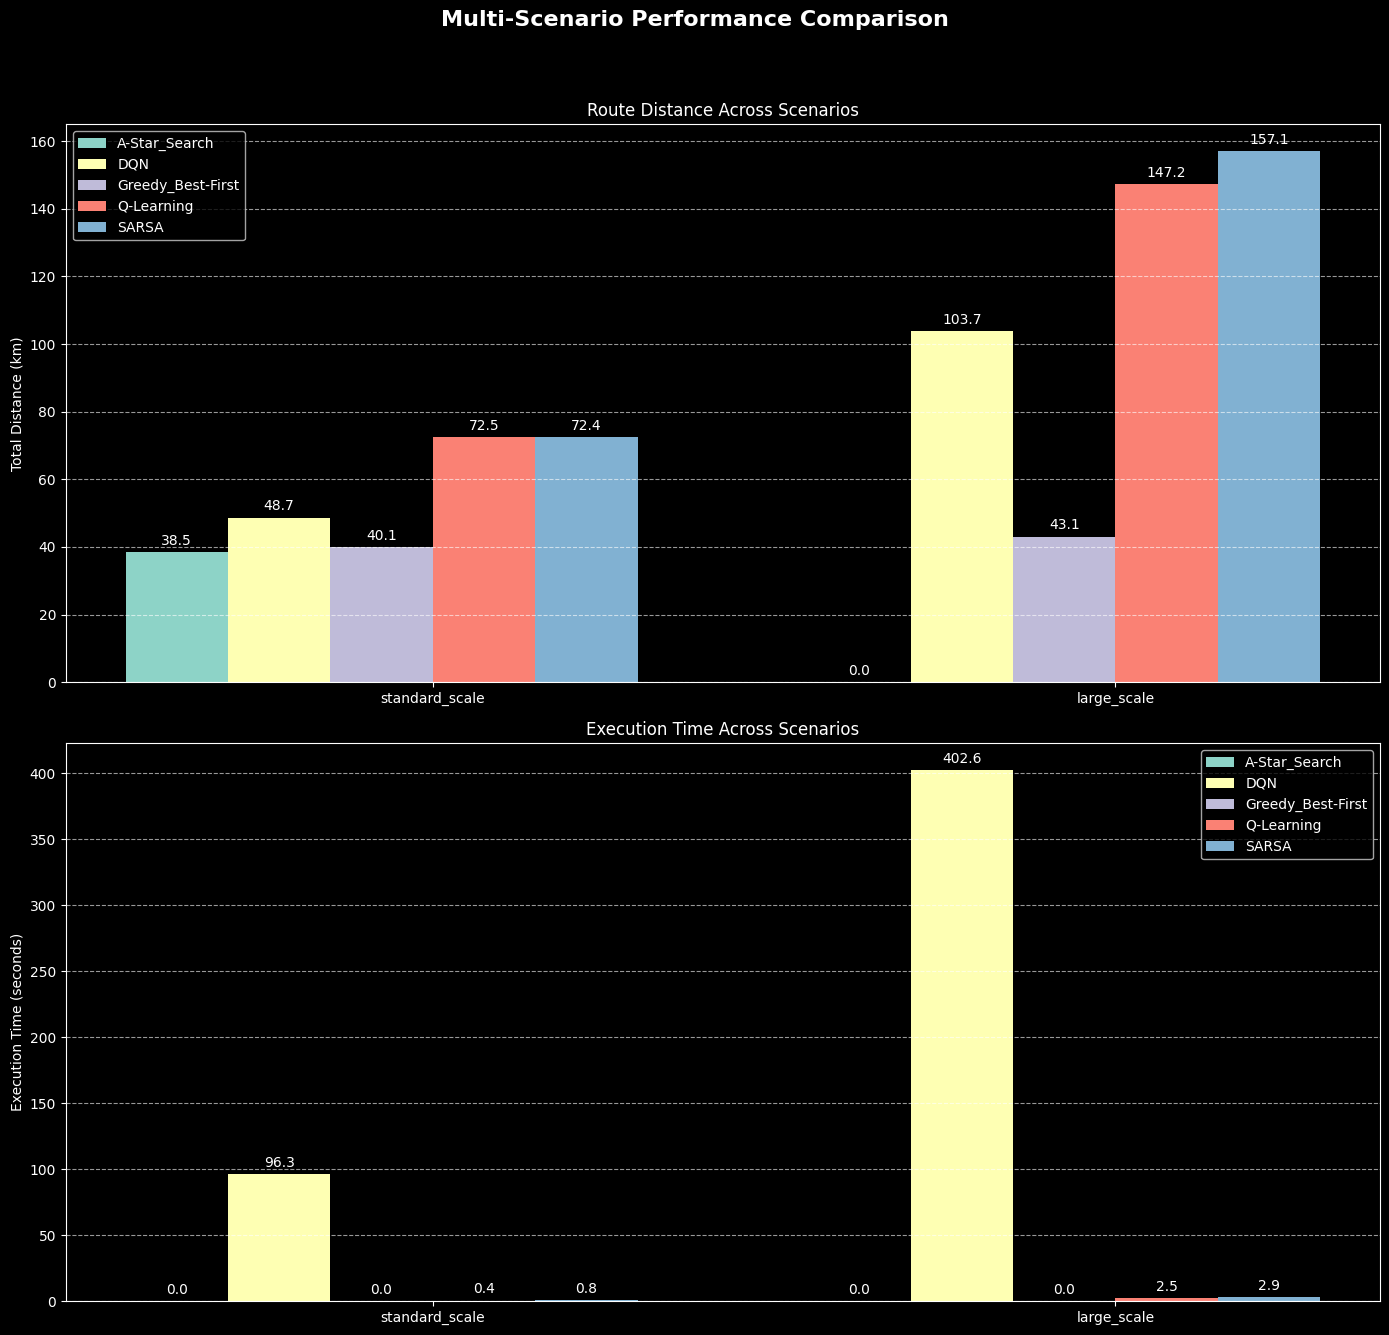

In [7]:
if all_scenario_results:
    plot_multi_scenario_comparison(all_scenario_results, "visualisations")
